✅ Model loaded successfully!
    BuildingArea  Lattitude  Longtitude  Type_h  Type_t  Type_u
0          156.0  -37.90380   145.00010     1.0     0.0     0.0
1          131.0  -37.75390   144.96120     1.0     0.0     0.0
3          100.0  -37.88630   145.06600     0.0     0.0     1.0
6           84.0  -37.82258   145.01930     0.0     0.0     1.0
11         130.0  -37.78703   144.84569     1.0     0.0     0.0
Ensemble 3, ZoMBI Activation 20 / 20 : [❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚        ] 10 / 10 experiments completed . . .                                    

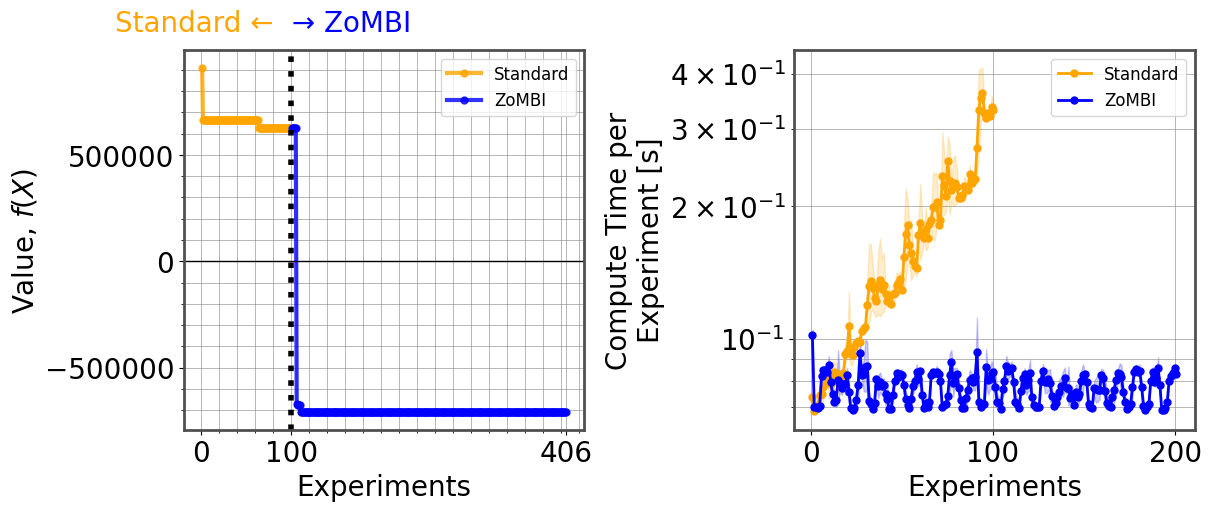

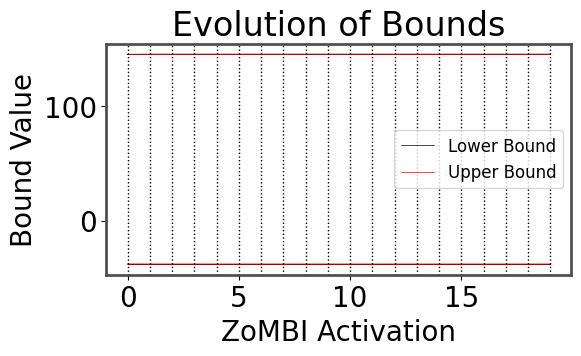

최적 위도 (Latitude): -37.9419
최적 경도 (Longitude): 145.0152
예측된 최저 가격 (Price): $973,892.00
총 연산 시간 (sec): 104.79
실험 횟수 (Iterations): 3
[[-37.9038  145.0001 ]
 [-37.7539  144.9612 ]
 [-37.8863  145.066  ]
 ...
 [-37.78363 145.0165 ]
 [-37.78363 145.0165 ]
 [-37.78363 145.0165 ]] [[ 911262.    666507.26  666507.26 ... -711138.5  -711138.5  -711138.5 ]
 [ 911262.    666507.26  666507.26 ... -711138.5  -711138.5  -711138.5 ]
 [ 911262.    666507.26  666507.26 ... -711138.5  -711138.5  -711138.5 ]]


In [23]:
import joblib
import pandas as pd
import numpy as np
from skopt import gp_minimize  # BO 최적화
from skopt.space import Real
from zombi import *
import time 

# 1. 데이터 및 모델 로드
df = pd.read_csv("melb_split.csv")  # 멜버른 데이터셋 로드

model_path = "/data/ephemeral/home/Sojeong/level4-cv-finalproject-hackathon-cv-02-lv3/Sojeong/search/ZoMBI/autoML.pkl"  # 저장된 pkl 파일 경로
price_model = joblib.load(model_path)

print("✅ Model loaded successfully!")

# 2. 불필요한 컬럼 제거 및 결측치 처리
drop_tables = ['Suburb', 'Address', 'Rooms', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode',
               'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'CouncilArea',
               'Regionname', 'Propertycount', 'Split']

df = df.drop(drop_tables, axis=1)
df = df.dropna(axis=0)

index = 0.1 < df['BuildingArea']  # BuildingArea 0값 제거
df = df.loc[index]

# 3. 타겟 변수 및 특성 분리
train_data = pd.get_dummies(df, dtype='float')
y_train = train_data['Price']
X_train = train_data.drop(['Price'], axis=1)
print(X_train.head())

# 4. 사용할 변수 선택 (위도, 경도, 건물 면적)
features = ["Lattitude", "Longtitude"]
target = "Price"

# 5. 위도 및 경도 최적화 범위 설정
LAT_MIN, LAT_MAX = -38.18255, -37.40853  # 위도 하한선, 상한선
LON_MIN, LON_MAX = 144.43181, 145.5264  # 경도 하한선, 상한선

# 6️. 입력 변수 X (최적화할 값)
dataset_X = df[features].values  # (n, 2) 형태
dataset_X[:, 0] = np.clip(dataset_X[:, 0], LAT_MIN, LAT_MAX)  # 위도 제한
dataset_X[:, 1] = np.clip(dataset_X[:, 1], LON_MIN, LON_MAX)  # 경도 제한

# 전첵 특성
expected_features = X_train.columns

# Price 예측 함수 (모델 기반)
def predict_price(X):
    """ 주어진 X (위도, 경도)에서 Price 예측 """
    X_df = pd.DataFrame(np.zeros((X.shape[0], len(expected_features))), columns=expected_features)
    X_df[features] = X  # 최적화 대상 변수만 변경
    return -price_model.predict(X_df)

# 7️. 초기 샘플 (최적화 시작점)
init_X = dataset_X[:5]  # 초기 샘플 5개 선택
init_fX = predict_price(init_X)

# 8. ZoMBI 실행
start_time = time.time()

# ZoMBI 
zombi = ZoMBI(
    dataset_X=dataset_X,
    dataset_fX=predict_price(dataset_X),
    fX_model=predict_price,
    BO=EI_abrupt, # acquisition function options: LCB, EI, LCB_ada, EI_abrupt
    nregular = 100, # number of regular BO experiments before ZoMBI, reduce before running your own experiments
    activations=20, # number of ZoMBI activations
    memory=5,  # number of memory points to retain per ZoMBI activation
    forward=10, # number of forward experiments per ZoMBI activation
    ensemble=3 # number of ensemble runs
)
# 9. 최적화 실행
zombi.optimize(init_X, init_fX, plot_f=True)

# 최적화 실행 후 걸린 시간
end_time = time.time()
total_time = end_time - start_time

# 최적화된 값이 위도/경도 범위를 초과하지 않도록 처리
def clip_solution(X):
    """ 최적화된 X 값이 허용된 위도/경도 범위를 초과하지 않도록 제한 """
    X[:, 0] = np.clip(X[:, 0], LAT_MIN, LAT_MAX)  # 위도 제한
    X[:, 1] = np.clip(X[:, 1], LON_MIN, LON_MAX)  # 경도 제한
    return X

# 최적화된 값을 제한 범위 내로 조정
zombi.X = clip_solution(zombi.X)

# 10. 최적해, 최적값, 최적화 횟수 
optimal_location = zombi.X[np.argmin(zombi.fX)]
optimal_price = -np.min(zombi.fX)
num_iterations = len(zombi.fX)  # 실행된 최적화 횟수

print(f"최적 위도 (Latitude): {optimal_location[0]}")
print(f"최적 경도 (Longitude): {optimal_location[1]}")
print(f"예측된 최저 가격 (Price): ${optimal_price:,.2f}")
print(f"총 연산 시간 (sec): {total_time:.2f}")
print(f"실험 횟수 (Iterations): {num_iterations}")

print(zombi.X, # .X grabs all X values
      zombi.fX_min) # .fX grabs running minimum fX values

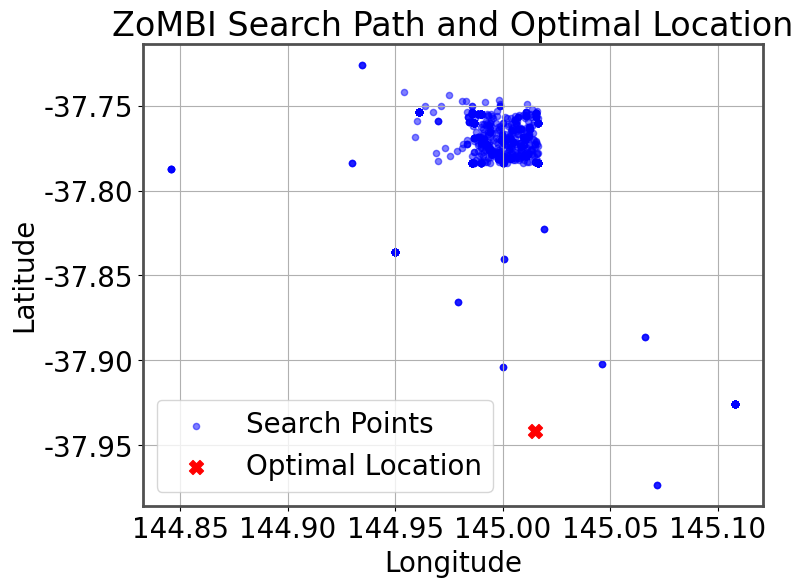

In [28]:
import matplotlib.pyplot as plt

# Extract latitude and longitude coordinates
latitudes = zombi.X[:, 0]
longitudes = zombi.X[:, 1]

# Extract the best (optimal) location
best_lat, best_lon = zombi.X[np.argmin(zombi.fX)]

# Plot the graph
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, c="blue", alpha=0.5, s=20, label="Search Points")
plt.scatter(best_lon, best_lat, c="red", marker="X", s=100, label="Optimal Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("ZoMBI Search Path and Optimal Location")
plt.legend()
plt.grid(True)
plt.show()
